In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.ticker as mtick

from scipy import stats

from matplotlib import pyplot
from matplotlib.ticker import MultipleLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans

In [2]:
# Set global parameters
sns.set(style="ticks")
palette = sns.color_palette('colorblind')

In [3]:
# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)

# 1. Question – What makes a Munro popular?

In [4]:
# Load dataset
munro = pd.read_csv('datasets/clean.csv')
munro.head()

,name,altitude,ascent_count,rating,region,report_count,rating_count,bb_count,hotel_count,hostel_count,...,neighbor_count_0_5,neighbor_count_5_20,nearest_city_dist,nearest_city_population,population_0_25,population_25_50,population_50_75,population_75_100,beginner_friendly,national_park
0,Ben Nevis,1345,17902,3.84,Fort William,316,253,72,41,18,...,5,24,6.68,10459,10459,0,8575,223189,0,NaN
1,Ben Macdui,1309,10449,3.78,Cairngorms,215,162,37,29,9,...,7,13,56.26,70000,0,0,158093,604889,0,Cairngorms
2,Braeriach,1296,6035,3.95,Cairngorms,141,94,37,29,9,...,3,17,53.49,70000,0,0,150894,612088,0,Cairngorms
3,Cairn Toul,1291,5121,3.86,Cairngorms,136,83,37,29,9,...,6,15,56.30,70000,0,0,205053,566929,0,Cairngorms
4,Sgor an Lochain Uaine,1258,4832,3.83,Cairngorms,139,79,37,29,9,...,6,14,55.43,70000,0,0,158093,613889,0,Cairngorms


### 1. Visualise the distribution of Munro heights and frequency of them being climbed

#### Distribution of Number of Ascents and Altitude

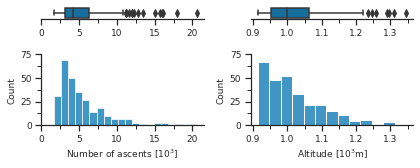

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 2.5))
((ax_box1, ax_box2), (ax_hist1, ax_hist2)) = axes

# 1. Boxplot and Histogram for outlier Munros
# Box plot
sns.boxplot(x=munro['ascent_count']/1000, ax=ax_box1, color=palette[0])
sns.despine(ax=ax_box1, left=True)  # Remove border
ax_box1.get_yaxis().set_visible(False)
ax_box1.set_xlabel(None)

# Histogram
sns.histplot(munro['ascent_count']/1000, ax=ax_hist1, bins='fd', color=palette[0])
sns.despine(ax=ax_hist1)  # Remove border
ax_hist1.set_ylabel('Count', fontsize = 9)
ax_hist1.set_xlabel('Number of ascents [$10^3$]', fontsize = 9)

# Increase tick frequency for x-axis
ax_box1.xaxis.set_ticks(np.arange(0, 21, step=5))
ax_hist1.xaxis.set_ticks(np.arange(0, 21, step=5))
# Increase tick frequency for y-axis
ax_hist1.yaxis.set_ticks(np.arange(0, 100, step=25))


# 2. Boxplot and Histogram for outlier Munros
# Box plot
sns.boxplot(x=munro['altitude']/1000, ax=ax_box2, color=palette[0])
sns.despine(ax=ax_box2, left=True)  # Remove border
ax_box2.get_yaxis().set_visible(False)
ax_box2.set_xlabel(None)

# Histogram
sns.histplot(munro['altitude']/1000, ax=ax_hist2, bins='fd', color=palette[0])
sns.despine(ax=ax_hist2)  # Remove border
ax_hist2.set_ylabel('Count', fontsize = 9)
ax_hist2.set_xlabel('Altitude [$10^3$m]', fontsize = 9)

# Increase tick frequency for x-axis
ax_box2.xaxis.set_ticks(np.arange(0.9, 1.4, step=0.1))
ax_hist2.xaxis.set_ticks(np.arange(0.9, 1.4, step=0.1))
# Increase tick frequency for y-axis
ax_hist2.yaxis.set_ticks(np.arange(0, 100, step=25))


# Fix axis font size
for ax in ax_box1, ax_hist1, ax_box2, ax_hist2:
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
ax_hist1.xaxis.set_minor_locator(MultipleLocator(2.5))
ax_hist1.yaxis.set_minor_locator(MultipleLocator(12.5))
ax_hist2.xaxis.set_minor_locator(MultipleLocator(0.05))
ax_hist2.yaxis.set_minor_locator(MultipleLocator(12.5))
ax_box2.xaxis.set_minor_locator(MultipleLocator(0.05))
ax_box1.xaxis.set_minor_locator(MultipleLocator(2.5))


# Store figure
plt.tight_layout()
plt.savefig("report/box_dist.pdf", bbox_inches='tight')
plt.show()

#### Determine outlier cutoff values

- The boxplot indicates that, in terms of number of ascents, an outlier is any Munro for which the number of ascents is above ~11,000. We now determine this value exactly:

In [6]:
# Code snippet adapted from: https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot
Q1 = munro['ascent_count'].quantile(0.25)
Q3 = munro['ascent_count'].quantile(0.75)
IQR = Q3 - Q1 # Interquartile range

cutoff_ascent_count = Q3 + 1.5 * IQR
cutoff_ascent_count = int(cutoff_ascent_count.round(0))  # Round to the nearest integer
print('Cutoff ascent count for outlier:  {}'.format(cutoff_ascent_count))

Cutoff ascent count for outlier:  11018


- The boxplot indicates that, in terms of altitude, an outlier is any Munro with a height above ~1250m. Again, we determine this value exactly:

In [7]:
# Code snippet adapted from: https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot
Q1 = munro['altitude'].quantile(0.25)
Q3 = munro['altitude'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

cutoff_altitude = Q3 + 1.5 * IQR
cutoff_altitude = int(cutoff_altitude.round(0))  # Round to the nearest integer
print('Cutoff altitude for outlier:  {}'.format(cutoff_altitude))

Cutoff altitude for outlier:  1229


#### Joint distribution of altitude and ascent count

We wish to get a summary view of both variables at once. To that end, we plot the joint distribution of altitude and ascent.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/axisgrid.py:1668: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


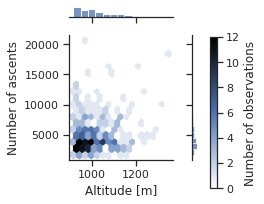

In [8]:
# Joint distribution
ax = sns.jointplot(x='altitude', y='ascent_count', data=munro, kind='hex', height=3, palette=palette)
plt.ylabel('Number of ascents')
plt.xlabel('Altitude [m]')
plt.tight_layout()

# Add colorbar
cbar_ax = ax.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Number of observations')


plt.savefig("report/heatmap_joint_distribution.pdf", bbox_inches='tight')
plt.show()

The above plot tells us that the majority of Munros has an altitude between 900 and 1000m, and an ascent count of 2500 to 3000. As we previously noted, there are apparent outliers. We treat these below:

### 2. Identify outliers and reason about them

In [9]:
# Separate outliers and non-outliers
mask_outliers = (munro['ascent_count'] <= cutoff_ascent_count) & (munro['altitude'] <= cutoff_altitude)
df_no_outliers = munro.loc[mask_outliers]
df_outliers = munro.loc[~mask_outliers]

In [10]:
df_outliers['name']

0                      Ben Nevis
1                     Ben Macdui
2                      Braeriach
3                     Cairn Toul
4          Sgor an Lochain Uaine
5                     Cairn Gorm
6      Aonach Beag (Nevis Range)
9                     Ben Lawers
20                     Lochnagar
46                   Beinn Ghlas
57                  Schiehallion
117                    Beinn Ime
164      Ben Vorlich (Loch Earn)
183                   Ben Lomond
218                       Driesh
246                The Cairnwell
249                  Ben Chonzie
252                        Mayar
258                Beinn Narnain
277                   Carn Aosda
Name: name, dtype: object

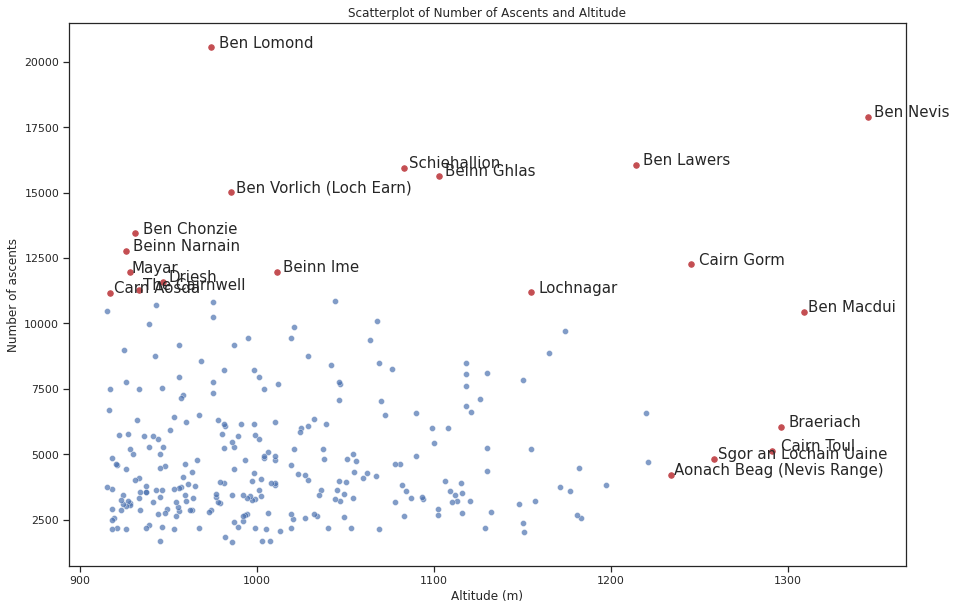

In [11]:
def show_outlier(row):
    plt.scatter(row['altitude'], row['ascent_count'], c='r', s=30)
    # Annotate outlier, add random noise to x,y coordinates to remedy overlaps
    plt.annotate(row['name'], (row['altitude']+np.random.uniform(5), row['ascent_count']+np.random.uniform(20)), size=15)

plt.figure(figsize=(15,10))
sns.scatterplot(x='altitude', y='ascent_count', data=df_no_outliers, alpha = 0.7)

# Annotate outliers
df_outliers.apply(show_outlier, axis=1)

plt.title('Scatterplot of Number of Ascents and Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Number of ascents')
plt.show()

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


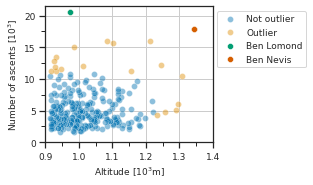

In [12]:
fig = plt.figure(figsize=(3,2.5))

# Note: we scale variables appropriately
# Plot regular
sns.scatterplot(x=df_no_outliers['altitude']/1000, y=df_no_outliers['ascent_count']/1000, label='Not outlier', alpha=0.45, color=palette[0])

# Plot outliers
sns.scatterplot(x=df_outliers['altitude']/1000, y=df_outliers['ascent_count']/1000, label='Outlier', alpha=0.45, color=palette[1])

# Plot identified outliers
for color, identified_outlier in zip(palette[2:], ['Ben Lomond', 'Ben Nevis']):
    b = munro.loc[munro['name'] == identified_outlier]
    sns.scatterplot(b['altitude']/1000, b['ascent_count']/1000, label=identified_outlier, alpha=1, color=color)

plt.xlabel('Altitude [$10^3$m]', fontsize = 9)
plt.ylabel('Number of ascents [$10^3$]', fontsize = 9)

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 9)
ax.set_yticks(list(range(0, 25, 5)))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(2.5))

legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={ 'size': 9 })
ax.grid()
plt.ylim(bottom=0)
plt.xlim(left=0.9, right=1.4)


plt.savefig("report/scatterplot.pdf", bbox_inches='tight')
plt.show()

There are some noticeable outliers. However, as the <insert reasoning\> about e.g. Ben Nevis or Ben Lomond shows, it is completely possible to attain these datapoints. They are therefore valid and shall be included in our statistical analysis.

### 3. Is there a statistically significant relationship between height and frequency of climb?

Note: we do not work with frequency of climb, but rather with the number of climbs.
Judging by the above scatterplot, there appears to be no apparent, strong relationship between said variables. However, the outliers (e.g. Ben Nevis) exert a leverage and we expect to see a positive relationship between number of ascents and altitude. Our conclusions will be marred due to the large variance in the left-hand side of the scatterplot.

<!-- lmk what you think about the wording please, ofc please correct anything that's off, thank you -->

Define the null and alternate hypotheses:

$H_0$ = there is _not_ a statistically significant relationship between altitude and number of ascents.

$H_a$ = there _is_ a statistically significant relationship between altitude and number of ascents.

We apply linear regression and observe the output of `statsmodels`. This will show us whether the relationship between ascent couunt and altitude could be due to chance.

Before applying OLS we need to make sure that our dependent variable is not highly skewed. In order to see if that is the case, we plotted the distribution of the Ascent Count. We notice that the distribution is right-skewed. In order to fix this skew, we use log-transform Ascent Count. This yields a distribution which is less skewed and which looks approximately normal.

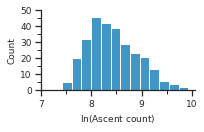

In [13]:
plt.figure(figsize=(3,2))
ax_log = plt.gca()

sns.histplot(np.log(munro['ascent_count']), ax=ax_log, color=palette[0])
sns.despine(ax=ax_log)

# Set labels
ax_log.set_xlabel('$\ln$(Ascent count)', fontsize=9)
ax_log.set_ylabel('Count', fontsize = 9)
ax_log.yaxis.set_ticks(np.arange(0, 60, step=10))

# Set x- and y-axis tick frequency
ax_log.xaxis.set_tick_params(labelsize=9)
ax_log.yaxis.set_tick_params(labelsize=9)
ax_log.xaxis.set_minor_locator(MultipleLocator(0.5))
ax_log.yaxis.set_minor_locator(MultipleLocator(5))
plt.xlim(7,None)

# Export plot
plt.tight_layout()
plt.savefig('report/ascent_count_distribution.pdf', bbox_inches='tight')
plt.show()

In [14]:
# Fit model
model = smf.ols('np.log(ascent_count) ~ altitude', data=munro)
results_altitude = model.fit()

In [15]:
print(results_altitude.summary())

                             OLS Regression Results                             
Dep. Variable:     np.log(ascent_count)   R-squared:                       0.016
Model:                              OLS   Adj. R-squared:                  0.012
Method:                   Least Squares   F-statistic:                     4.514
Date:                  Mon, 12 Apr 2021   Prob (F-statistic):             0.0345
Time:                          18:45:52   Log-Likelihood:                -203.86
No. Observations:                   282   AIC:                             411.7
Df Residuals:                       280   BIC:                             419.0
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6578      0.364

The second error message indicates that there is numerical instability (multicollinearity is out of question as there is a single predictor). We remedy this by centering the independent variable around 0.

In [16]:
# Apply normalization
munro_mod = munro.copy()
munro_mod['altitude'] = munro_mod['altitude'] - munro_mod['altitude'].mean()

# Fit model
model = smf.ols('np.log(ascent_count) ~ altitude', data=munro_mod)
results_altitude = model.fit()

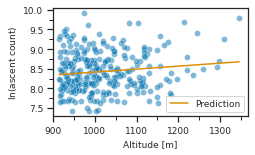

                             OLS Regression Results                             
Dep. Variable:     np.log(ascent_count)   R-squared:                       0.016
Model:                              OLS   Adj. R-squared:                  0.012
Method:                   Least Squares   F-statistic:                     4.514
Date:                  Mon, 12 Apr 2021   Prob (F-statistic):             0.0345
Time:                          18:45:56   Log-Likelihood:                -203.86
No. Observations:                   282   AIC:                             411.7
Df Residuals:                       280   BIC:                             419.0
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4286      0.030

In [17]:
plt.figure(figsize=(3.5,2))

# Scatterplot
log_ascent = np.log(munro['ascent_count'])
sns.scatterplot(data=munro, y=log_ascent, x='altitude', alpha=0.5, color=palette[0])

# Plot fit
y_hat = results_altitude.predict(munro_mod['altitude'])  # Predicted data
sns.lineplot(x=munro['altitude'], y=y_hat, color=palette[1], label='Prediction')


plt.xlabel('Altitude [m]', fontsize = 9)
plt.ylabel('$\ln$(ascent count)', fontsize = 9)

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 9)
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

plt.xlim(left=900)
plt.legend(prop={ 'size': 9 })

# Export plot
plt.savefig('report/q1_prediction.pdf', bbox_inches='tight')
plt.show()

# Evaluate fit
print(results_altitude.summary())

- The $p$-value tells us that there is a ~3.4% probability that the relationship between altitude and log of ascent count may be due to chance. Since 0.034 < 0.05, it allows us to reject the null hypothesis that the coefficient of altitude in the model equals 0 at the 5% level. Furthermore, the t score is fairly high too, to further assert our claim. Thus, there is a statistically significant relationship between altitude and ascent count.
- However,we observe that the $R^2$ value is quite low at 0.016. This tells us that the model does not fit the data too well. This motivates the use of further predictors to aid our analysis.
- Intercept: Since we normalized the independent variable (i.e. it has mean 0), the intercept tells us the expected logascent count for a Munro of mean altitude. NEW! The expected ascent count is then $e^{8.4286}\approx 4576$
- Coefficient: A unit increase in altitude leads to ascent count increasing by $100(e^{0.0008}-1)\%\approx0.08\%$. The confidence interval tells us that in 95% of all samples that could be drawn, $[5.57\times 10^{-5}, 0.001]$ will include the true value of the coefficient for altitude, i.e. that the increase in ascent count will be within $[0.00570, 0.100]\%$
- The reason is that the linear regression is of the form $\beta_0+\beta_1x=\ln(y)$ so that $\beta_0+\beta_1x_1=\ln(y_1)$ and $\beta_0+\beta_1x_2=\ln(y_2)$ for two separate observations. Then $\beta_1(x_2-x_1)=\ln(y_2)-\ln(y_1)=\ln(y_2/y_1)$. Now we are interested in the unit increase, so that $x_2-x_1=1$, and finally $e^{\beta_1}=\frac{y_2}{y_1}$, which can be rewritten as $e^{\beta_1}-1=\frac{y_2-y_1}{y_1}$. Finally, this yields $100(e^{\beta_1}-1)=100\left(\frac{y_2-y_1}{y_1}\right)$

#### Inspect heteroscedasticity

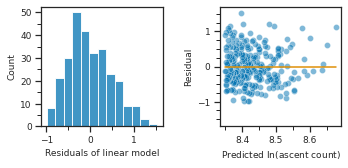

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(5,2.5))
ax1, ax2 = axes

# Plot the distribution of residuals
sns.histplot(results_altitude.resid, ax=ax1, color=palette[0])
ax1.set_xlabel('Residuals of linear model', fontsize=9)
ax1.set_ylabel('Count', fontsize=9)

ax1.tick_params(axis = 'both', which = 'major', labelsize=9)
ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(MultipleLocator(5))

# Plot residuals against predicted valueus
scatter = sns.scatterplot(x=y_hat, y=results_altitude.resid, ax=ax2, alpha=0.5, color=palette[0])
sns.lineplot(x=y_hat, y=0, color=palette[1], ax=ax2)
ax2.set_ylabel('Residual', fontsize=9)
ax2.set_xlabel('Predicted $\ln$(ascent count)',fontsize=9)

ax2.tick_params(axis = 'both', which = 'major', labelsize=9)
ax2.xaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(MultipleLocator(0.25))
ax2.set_ylim(-1.7,1.7)

plt.tight_layout()
plt.savefig('report/uni_residuals.pdf', bbox_inches='tight')
plt.show()

- An assumption of linear regression is that the residuals to be normally distributed. This appears to be the case.
- The plot is not heteroskedastic. There is no obvious pattern observed – the independent variable and variance do not exhibit a relationship. 
- Therefore, a linear model is a resonable choice.

## 2. Question – Identify other factors

We only pick continuous features here, since the feature selection technique expects continuous features. This means we have ignored columns which have categorical and boolean data. In addition, we ignore `rating_count`, since it is not an inherent property of a Munro, and learning about its importance wouldn't provide useful insight. Lastly, we also removed `ascent_count` as it is the dependent variable of the statistical problem at hand.

In [19]:
irrelevant_cols = ['name', 'ascent_count', 'rating', 'region', 'report_count', 
                    'rating_count', 'island', 'county', 'latitude', 'longitude']
boolean_cols = ['beginner_friendly']
categorical_cols = ['national_park', 'island']

# Feature selection can only be applied to continuous variables
irrelevant_cols.extend(boolean_cols)
irrelevant_cols.extend(categorical_cols)

munro_subset = munro.loc[:, ~munro.columns.isin(irrelevant_cols)]
munro_subset.head()

,altitude,bb_count,hotel_count,hostel_count,cottage_count,camping_count,neighbor_count_0_5,neighbor_count_5_20,nearest_city_dist,nearest_city_population,population_0_25,population_25_50,population_50_75,population_75_100
0,1345,72,41,18,147,147,5,24,6.68,10459,10459,0,8575,223189
1,1309,37,29,9,182,182,7,13,56.26,70000,0,0,158093,604889
2,1296,37,29,9,182,182,3,17,53.49,70000,0,0,150894,612088
3,1291,37,29,9,182,182,6,15,56.30,70000,0,0,205053,566929
4,1258,37,29,9,182,182,6,14,55.43,70000,0,0,158093,613889


## Standardize data

Now that we have our subset data with all relevant features, we will standardize the dataset to make sure that the data can effectively undergo statistical analysis. This will help with numerical stability because features in `munro_subset` have different range of values (e.g. population can be in the thousands, whereas hotel_count is in the tens). As a result, we decided to go ahead with Scikit Learn's StandardScaler class.

In [20]:
standardized_data = StandardScaler().fit_transform(munro_subset)
scaled_munro = pd.DataFrame(standardized_data, index=munro_subset.index, columns=munro_subset.columns)

## Feature selection

#### 1. Correlation ranking of single features

We use scikit-learn's SelectKBest class to select features. We score the features using the scoring function `f_regression`, which is equivalent to running univariate linear regression test for each regressor (independent variable). 

According to [the official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html), `f_regression` first computes  the Pearson correlation coefficient between the regressor and the target. It outputs a $p$-value, which corresponds to the null hypothesis that there is _no_ linear interaction between between the regressor and the target. (["eickenberg"'s response](https://stackoverflow.com/questions/23677734/whats-the-meaning-of-p-values-which-produced-by-feature-selection-i-e-chi2-me)). 

We pick the regressors whose $p$-value falls below a certain threshold. As in the previous section, we choose the threshold to be 0.05, such that the null hypothesis can be rejected at the 5% level. That is, we pick only those regressors, for which there is a 5% probability that the linear interaction with the target is due to chance.

(As "MrDrFenner" puts it ([source](https://stats.stackexchange.com/questions/204141/difference-between-selecting-features-based-on-f-regression-and-based-on-r2)), `f_regression` is essentially "correlation ranking of single features".)

In [21]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X=scaled_munro, y=munro['ascent_count'])  # learn relationship from training data

p_value_threshold = 0.05
selected_features = []
for p_value, feature in zip(fs.pvalues_, scaled_munro.columns):
    if p_value <= p_value_threshold:
	    selected_features.append(feature)

We now filter out those selected feautres, and use it for analysis.

In [22]:
# Pick only significant features
scaled_munro = scaled_munro[selected_features]

#### 2. Treat multicollinearity between features

Before we start using ordinary least squares on the data, we need to make sure that there is no significant multicollinearity between the features. This may reduce the numerical stability, and hence the quality of our prediction. To determine multicollinear features, we inspect the correlation matrix for the selected independent features. Darker colors indicate high positive correlation.

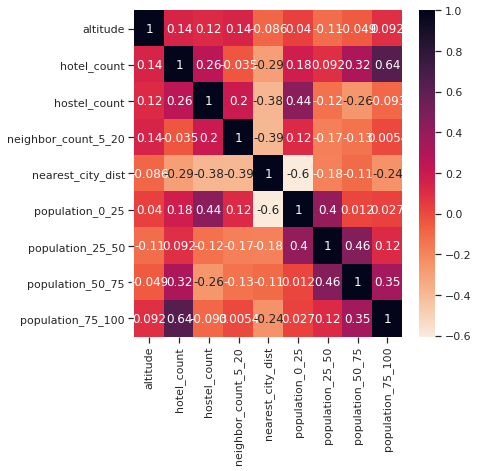

In [23]:
import matplotlib

plt.figure(figsize=(6,6))
cmap = matplotlib.cm.get_cmap('rocket_r')  # Invert color map such that dark => high
sns.heatmap(scaled_munro.corr(), annot=True, cmap=cmap)

plt.savefig('report/correlation_matrix.pdf', bbox_inches='tight')

plt.show()

Conclusion: None of the correlations is significant, i.e. above 0.8, so we do not remove any features.

## Multivariate linear regression

We will use each of the standardized features as regressors and the log-transformed Ascent Count as the target. We reintroduce categorical and boolean features and run multivariate linear regression.

In [24]:
df_all = scaled_munro.copy()
df_all['intercept'] = 1  # consider intercept when fitting the model

# Add categorical and boolean regressors
df_boolean_and_categorical = pd.get_dummies(munro[['region', 'county', 'island', 'national_park', 'beginner_friendly']], drop_first=True)

df_all = pd.concat([df_all, df_boolean_and_categorical], axis=1)

model = sm.OLS(np.log(munro['ascent_count']), df_all)
results_all = model.fit()
print(results_all.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     13.30
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           7.95e-41
Time:                        18:46:03   Log-Likelihood:                -47.494
No. Observations:                 282   AIC:                             173.0
Df Residuals:                     243   BIC:                             315.0
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

- We observe that there is numerical instability, likely due to high multicollinearity. This is likely due to the fact that the distance- and population-related from the previous model are a proxy to the categorical variables, which themselves convey information about location.
- Due to the numerical issues as well as reduced interpretability, we choose not to include categorical and boolean variables.

We thus only consider continuous features. We will now apply ordinary least squares regression to the dataset:

In [25]:
X = scaled_munro.copy()
X['intercept'] = 1  # consider intercept when fitting the model

model = sm.OLS(np.log(munro['ascent_count']), X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     35.87
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           1.95e-41
Time:                        18:46:03   Log-Likelihood:                -95.782
No. Observations:                 282   AIC:                             211.6
Df Residuals:                     272   BIC:                             248.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
altitude                0.0762    

We notice `population_25_50` and `hostel_count` have quite a high $p$-value of above 0.2. This might be due to multicollinearity with other population and accommodation related features. We therefore drop these features:

In [26]:
# Running multivariate with dropped features
X = scaled_munro.copy()
X['intercept'] = 1  # consider intercept when fitting the model
del X['population_25_50']
del X['hostel_count']

model = sm.OLS(np.log(munro['ascent_count']), X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     45.39
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           2.27e-42
Time:                        18:46:03   Log-Likelihood:                -97.554
No. Observations:                 282   AIC:                             211.1
Df Residuals:                     274   BIC:                             240.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
altitude                0.0732    

#### Coefficient interpretation

On applying OLS on the data with `population_25_50` and `hostel_count` excluded, we notice that we get a decent fit with and adjusted $R^2$ of 0.525. We also notice that the F-statistic of the fit is quite high too. In addition, we notice that all the features in model have a $p$-value within 0.01. This indicates the obtained coefficients are reliable.

Since the regressors are standardized and the target is log-transformed, we transform them to an interpretable format.

We are interested in the impact of a unit change in a regressor on the target.
The linear regression is of the form 
$$\beta_0 + \beta_1z^{(1)}+...=\ln(y)$$
where $z^{(i)}$ is the $i$-th regressor, standardised. To interpret the response in the target to a unit increase in the $i$-th regressor, we let $x^{(j)}=0\ (\forall j\neq i)$. Then we have 

$$\beta_0 + \beta_iz^{(i)}=\ln(y)$$

Now
$$\beta_i\left(z_2^{(i)} - z_1^{(i)}\right) = \ln(y_2) - \ln(y_1)$$

Now since $z^{(i)}=\frac{x^{(i)}-\overline{x}^{(i)}}{\sigma_{x^{(i)}}}$ due to standardisation, we may rewrite the above as

$$\beta_i\frac{x_2^{(i)} - x_1^{(i)}}{\sigma_{x^{(i)}}} = \ln(y_2) - \ln(y_1)$$

Now we are interested in a unit increase in the regressor $x^{(i)}$, so then $x_2^{(i)} - x_1^{(i)}=1$ so that

$$\frac{\beta_i}{\sigma_{x^{(i)}}} = \ln(y_2) - \ln(y_1) = \ln\left(\frac{y_2}{y_1}\right)$$

which upon exponentiation and applying the laws of logarithms becomes

$$\exp\left(\frac{\beta_i}{\sigma_{x^{(i)}}}\right) = \frac{y_2}{y_1}$$

which we may rewrite as 

$$\exp\left(\frac{\beta_i}{\sigma_{x^{(i)}}}\right) - 1 = \frac{y_2}{y_1} - 1 = \frac{y_2-y_1}{y_1}$$

Thus, a unit increase in an original feature leads to a $100\left[\exp\left(\frac{\beta_i}{\sigma_{x^{(i)}}}\right) - 1\right]$ percent increase in Ascent Count.


We transform the coefficients accordingly:

In [27]:
coefficients = results.params.to_dict()
CIs = results.conf_int().T.to_dict()

features = []
coefficients_t = []
CI_lower_t = []
CI_upper_t = []

def transform(coef, std):
    return 100 * (np.exp(coef / std) - 1)

for key in coefficients.keys():
    # Ignore intercept
    if key == 'intercept':
        continue
    features.append(key)
    std = munro_subset[key].std()
    # Transform slope
    b = coefficients[key]
    coefficients_t.append(transform(b, std))
    # Transform confidence interval
    CI = CIs[key]
    CI_lower_t.append(transform(CI[0], std))
    CI_upper_t.append(transform(CI[1], std))

In [28]:
df_interpretation = pd.DataFrame({
    'Feature': features, 
    'Coefficient': coefficients_t,
    'CI Lower': CI_lower_t,
    'CI Upper': CI_upper_t
})
df_interpretation

,Feature,Coefficient,CI Lower,CI Upper
0,altitude,0.087413,0.037557,0.137294
1,hotel_count,-0.708382,-0.983607,-0.432393
2,neighbor_count_5_20,-1.308066,-1.808194,-0.805391
3,nearest_city_dist,-0.512404,-0.888344,-0.135039
4,population_0_25,0.002551,0.001321,0.003780
5,population_50_75,0.000033,0.000024,0.000041
6,population_75_100,0.000035,0.000028,0.000043


The intercept gives the estimated value of Ascent Count on a log scale when all regressors are 0. The intercept is $8.4286$ which implies the expected number of ascents is then $e^{8.4286}\approx4576$ ascents.


The most dominant feature is `neighbor_count_5_20`. Every extra neighboring Munro within 5-20km reduces the Ascent Count by ~1.3%. The other dominant features are the number of hotels, wherein each extra hotel reduces Ascent Count by ~0.71%, and the distance to the nearest city, such that each extra kilometer distance leads to a ~0.5% decrease in Munro popularity. As implied by the first section, altitude also has an impact on ascent count, albeit smaller. Namely, each meter of altitude increases Ascent Count by ~0.87%. There is also a slight positive impact on Ascent Count associated with poulation within 0-25km and 50-100km. 

The importance of hotel count is somewhat surprising. This may indicate that hotel count is a proxy for another variable that we did not include in our model.

#### Inspect heteroscedasticity

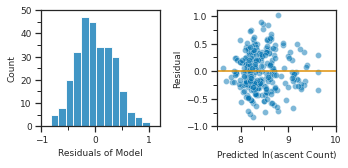

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(5,2.5))
ax_hist, ax_yhat = axes

# Plot the distribution of residuals
sns.histplot(results.resid, ax=ax_hist, color = palette[0])
ax_hist.set_xlabel('Residuals of Model', fontsize=9)
ax_hist.set_ylabel('Count', fontsize=9)
ax_hist.xaxis.set_minor_locator(MultipleLocator(0.5))
ax_hist.yaxis.set_minor_locator(MultipleLocator(5))
ax_hist.set_xlim(-1, 1.2)
ax_hist.set_ylim(0, 50)
ax_hist.tick_params(axis = 'both', which = 'major', labelsize=9)

# Plot residuals against dependent variable
sns.scatterplot(x=results.predict(X), y=results.resid, ax=ax_yhat, alpha=0.5, color=palette[0])
sns.lineplot(x=range(7, 11), y=0, color=palette[1], ax=ax_yhat)

ax_yhat.set_xlim(7.5, 10)
ax_yhat.set_ylim(-1, None)
ax_yhat.set_ylabel('Residual', fontsize=9)
ax_yhat.set_xlabel('Predicted $\ln$(ascent Count)', fontsize=9)
ax_yhat.tick_params(axis='both', which='major', labelsize=9)
ax_yhat.xaxis.set_minor_locator(MultipleLocator(0.5))
ax_yhat.yaxis.set_minor_locator(MultipleLocator(0.25))

plt.tight_layout()
plt.savefig('report/multi_residuals_dist.pdf', bbox_inches='tight')
plt.show()

- Errors are approximately normally distributed. This is nice to see, since this is an assumption of linear regression.
- We plot the residuals of our fit against predictions. We notice that the variance of the residuals does not increase with the fitted value. This shows that there is no heteroskedasticity.

## 3. Question – Cluster Munros according to their features

We will now move to our next question, which is to cluster Munros according to the independent features. This may help us discover a sub-structure within the dataset and help us understand it better.

## PCA

Before performing K-Means Clustering, we need to reduce the number of independent vectors. This is because as a distance-based method, K-Means suffers from the curse of dimensionality and will perform poorly when applied to a vast dataset. Hence, we perform PCA on the dataset.

In [30]:
standardized_data = StandardScaler().fit_transform(munro_subset)
df_clusters = pd.DataFrame(standardized_data, index=munro_subset.index, columns=munro_subset.columns)

pca = PCA().fit(df_clusters)

### Scree plot

To determine the appropriate number of PCA components to be used, we will be plotting a scree plot to find the knee.

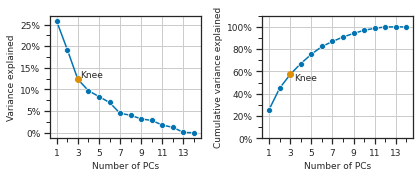

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 2.5))

y = pca.explained_variance_ratio_ * 100
x = range(1, len(y)+1)

# Scree plot (ax1)
sns.set_style("ticks")
sns.lineplot(x=x, y=y, marker='o', ax=ax1, color=palette[0])
ax1.set_ylabel('Variance explained', fontsize=9)
ax1.set_xticks(range(1, len(y)+1, 2))
ax1.set_xlabel('Number of PCs', fontsize=9)
ax1.grid()

# Cumulative scree plot
y2 = y.cumsum()
sns.lineplot(x=x, y=y2, marker='o', ax=ax2, color = palette[0])
ax2.set_ylabel('Cumulative variance explained', fontsize=9)
ax2.set_xticks(range(1, len(y)+1, 2))
ax2.set_xlabel('Number of PCs', fontsize=9)
ax2.set_ylim([0,110])
ax2.grid()


# Fix axis numbering
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(2.5))
ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.yaxis.set_minor_locator(MultipleLocator(10))
ax2.tick_params(axis='both', which='major', labelsize=9)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())


# Mark the knee
knee = 3
ax1.annotate('Knee', (knee + 0.2, y[knee-1] + 0.5), size=9)
ax1.plot(knee, y[knee-1], color=palette[1], marker='o')
ax2.annotate('Knee', (knee + 0.4, y2[knee-1] - 5), size=9)
ax2.plot(knee, y2[knee-1], color=palette[1], marker='o')


# Export plot
plt.tight_layout()
plt.savefig('report/scree_plot.pdf', bbox_inches='tight')
plt.show()

The scree plot shows that the first 3 principal components help explain a considerable amount of variance. Using the cumulative plot, we see that this is about 60% of the variance. The knee is indicated in red.

### PCA with fewer components

Using the results above, we transform the dataset and only include the first 3 principal components.

In [32]:
pc_scores = [f'PC{i+1}' for i in range(knee)]

In [33]:
# Reapply PCA to work with cleaner data
pca = PCA(n_components=knee)

# Transform original data using PC scores
transformed_values = pca.fit_transform(df_clusters)
df_transformed = pd.DataFrame(transformed_values, columns=pc_scores)

Having removed the less relevant PCs, we now interpret the relevant prinicipal components' loadings:

In [34]:
df_pca = pd.DataFrame(pca.components_, columns=df_clusters.columns, index=pc_scores).T

cm = sns.diverging_palette(240, 10, as_cmap=True)
df_pca.style.background_gradient(cmap=cm).set_precision(2)

,PC1,PC2,PC3
altitude,-0.15,-0.05,-0.04
bb_count,-0.46,0.17,-0.04
hotel_count,-0.29,0.35,-0.32
hostel_count,-0.46,-0.05,0.20
cottage_count,-0.40,-0.30,-0.19
camping_count,-0.40,-0.30,-0.19
neighbor_count_0_5,-0.07,-0.22,0.10
neighbor_count_5_20,-0.07,0.09,0.49
nearest_city_dist,0.21,-0.37,-0.37
nearest_city_population,-0.07,-0.19,-0.27


- PC1: People from the nearest city, which is 25 - 75km away, come to a Munro but they do not stay at an accommodation. There's a slight preference for shorter Munros. -> "Preferred by Locals".
- PC2: People from cities up to 100km away come to a Munro and they stay at a bed and breakfast, but preferably at a hotel. They seek a Munro which is further away from a nearby city. There slightly prefer if there are neighboring Munros nearby, but not too close by (neighbor_count_0_5 negative). -> "Preferred by people Going on a Trip"
- PC3: People from a nearby city within 25 km of the Munro come to a cheaper accommodation (hostel). They prefer if there are other Munros in the area (neighbor_count_5_20 positive). They too prefer to be further away from a nearby city. -> "Preferred by Serious Local Hikers"

To determine the appopriate number of clusters, we inspect the inertia (i.e. sum of squared errors) of K-Means model with increasing number of clusters.

In [35]:
inertia = []
for i in range(2, 12):
    K_means_sklearn_model = KMeans(n_clusters=i, random_state=42)
    K_means_sklearn_model.fit(df_transformed)
    inertia.append(K_means_sklearn_model.inertia_)

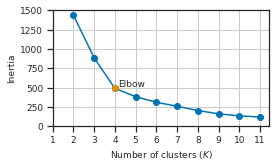

In [36]:
elbow = 4

plt.figure(figsize=(4, 2.5))
ax1 = plt.gca()

plt.plot(range(2,12), inertia, '-o', c=palette[0])
plt.xticks(range(0,12))
plt.ylabel('Inertia', fontsize=9)
plt.xlabel('Number of clusters ($K$)', fontsize=9)

plt.plot(elbow, inertia[elbow-2], color=palette[1], marker='o', label='elbow')
plt.annotate('Elbow', (elbow + 0.15, inertia[elbow-2] + 20), size=9)

ax1.set_xticks(range(0, 12))
ax1.set_yticks(range(0, 1600, 250))
ax1.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
plt.xlim(1,None)
plt.ylim(0,None)
plt.grid()

plt.savefig('report/k_screeplot.pdf', bbox_inches='tight')
plt.show()

There is a clear elbow at $K=4$. Thus, the optimal number of clusters is 4. We now perform K-Means. Since we cluster in 3 dimensions, we plot the predictions on a 3D plot and indicate the clusters' centroids.

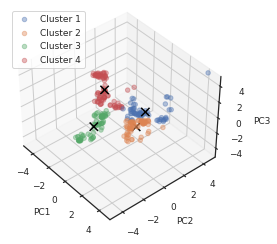

In [37]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

elbow = 4
K_means_sklearn_model = KMeans(n_clusters=elbow, random_state=42)
K_means_sklearn_model.fit(df_transformed)
prediction = K_means_sklearn_model.predict(df_transformed)
centres = K_means_sklearn_model.cluster_centers_

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

# Plot scatter plots
df_transformed['prediction'] = prediction
for i in range(0,4):
    df_sub = df_transformed.loc[df_transformed['prediction'] == i]
    ax.scatter(df_sub['PC1'], df_sub['PC2'], df_sub['PC3'], alpha=0.4, cmap=palette, label=f'Cluster {i+1}')

# Plot cluster centres
ax.scatter(centres[:,0], centres[:,1], centres[:,2], marker='x', s=70, alpha=1, c='black')

ax.legend(loc='upper left', prop={ 'size': 9 })
ax.set_xlabel('PC1', fontsize=9)
ax.set_ylabel('PC2', fontsize=9)
ax.set_zlabel('PC3', fontsize=9)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.tick_params(axis='y', which='major', labelsize=9)
ax.tick_params(axis='z', which='major', labelsize=9)


ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)

# Set angle of view
ax.azim = -40
ax.elev = 40

plt.savefig('report/3d_clusters.pdf', bbox_inches='tight')

plt.show()

The clusters above look good! We now use the information about clusters to inspect the features that contribute to each cluster. To obtain a summary measure for each feature, we take the mean of each feature for each cluster.

### Cluster interpretation

In [38]:
# Prepare dataset for interpretation of cluster features
df_temp = munro_subset.copy()

# Add information about clusters; Start numbering from 1
df_temp['clusters'] = prediction + 1
df_temp['ascent_count'] = munro['ascent_count']

# Scale the values
df_temp['ascent_count'] = df_temp['ascent_count'] / 1000
df_temp['nearest_city_population'] = df_temp['nearest_city_population'] / 1000
df_temp['population_0_25'] = df_temp['population_0_25'] / 1000
df_temp['population_25_50'] = df_temp['population_25_50'] / 1000
df_temp['population_50_75'] = df_temp['population_50_75'] / 1000_000
df_temp['population_75_100'] = df_temp['population_75_100'] / 1000_000

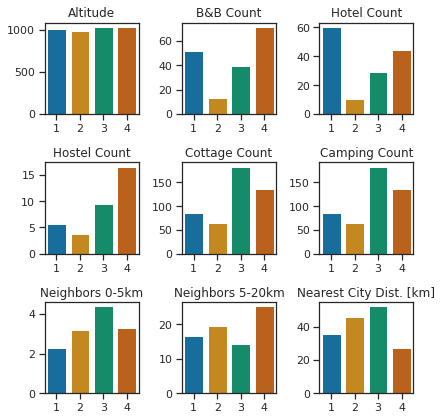

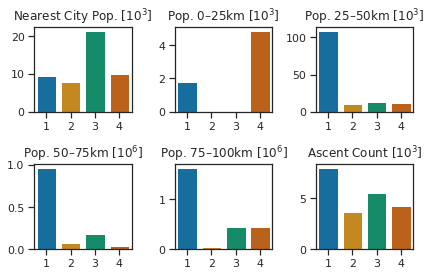

In [39]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Rename axes
titles = {
    'altitude': 'Altitude',
    'bb_count': 'B&B Count',
    'hotel_count': 'Hotel Count',
    'hostel_count': 'Hostel Count',
    'cottage_count': 'Cottage Count',
    'camping_count': 'Camping Count',
    'nearest_city_dist': 'Nearest City Dist. [km]',    
    'neighbor_count_0_5': 'Neighbors 0-5km',
    'neighbor_count_5_20': 'Neighbors 5-20km',
    'population_0_25': 'Pop. 0–25km [$10^3$]',
    'population_25_50': 'Pop. 25–50km [$10^3$]',
    'population_50_75': 'Pop. 50–75km [$10^6$]',
    'population_75_100': 'Pop. 75–100km [$10^6$]',
    'nearest_city_population': 'Nearest City Pop. [$10^3$]',
    'ascent_count': 'Ascent Count [$10^3$]',
    'clusters': 'clusters'
}

cols = df_temp.columns[df_temp.columns != 'clusters']
ncols = 3

# Plot first half
fig, axes = plt.subplots(ncols=ncols, nrows=3, figsize=(6,6))
for i, feature in enumerate(cols[:9]):
    row = i // ncols
    col = i % ncols
    ax = axes[row][col]    
    sns.barplot(x='clusters', y=feature, data=df_temp, ax=ax, ci=None, palette=palette)
    ax.set_ylabel(None)
    ax.set_title(titles[feature])
    ax.set_xlabel(None)
    # sns.despine(ax=ax)

fig.tight_layout()
plt.savefig('report/cluster_features_1.pdf', bbox_inches='tight')
plt.show()

# Plot second half
fig, axes = plt.subplots(ncols=ncols, nrows=2, figsize=(6,4))
for i, feature in enumerate(cols[9:]):
    row = i // ncols
    col = i % ncols
    ax = axes[row][col]    
    sns.barplot(x='clusters', y=feature, data=df_temp, ax=ax, ci=None, palette=palette)
    ax.set_ylabel(None)
    ax.set_title(titles[feature])
    ax.set_xlabel(None)
    # sns.despine(ax=ax)

fig.tight_layout()
plt.savefig('report/cluster_features_2.pdf', bbox_inches='tight')
plt.show()

In [40]:
# Used to find Munro examples
# munro.loc[df_temp['clusters'] == 4].sort_values('ascent_count', ascending=False)['name'].head(2)

- Cluster 1:
    - The average Munro in cluster 1 has ~2000 inhabitants within 25km, while the nearest city has ~10,000 inhabitants and is ~35km away. This cluster has the largest population 25-100km away out of all clusters. At about 60, it also has the largest number of hotels. It also has a fair amount of bed and breakfast accomodations (about 50). At slightly above 2 Munros, it has the lowest the number of neighbouring Munros. For example Ben Lomond and Ben Lawers fall in this category.
    - Since there are no neighbouring Munros and there are a lot of hotels near the Munro, we can say that these are fairly "exclusive" Munros which are suitable for visitors from a larger city. Making them fairly popular.

- Cluster 2:
    - The average Munro in cluster 2 does not have a large city within 100km. The nearest city is about ~45km away with a population slightly higher than ~7,500. The dominant accommodation type for this cluster are cottages and camping, and there are relatively few B&Bs, hotels and hostels. It has about 25 neighboring Munros within 20km. For example Mount Keen and Ben Hope belong to this cluster.
    - A region with a fair amount neighbouring Munros, with not many accomodation facilities and are also further away from any major city. Making them fairly less popular.

- Cluster 3:
    - For the average Munro in cluster 3, the closest city is more than 50km away, but has ~20,000 people – the most across all clusters. It has the largest number of cottages and campings out of all clusters, with relatively fewer B&Bs, hotels and hostels. At more than 4, it also has the largest number of neighboring Munros within 5km. For example Cairn Gorm and The Cairnwell belong here.
    - These Munros are fairly popular – perhaps some inhabitants of the nearby large city are regular visitors, or the high concentration of nearby Munros makes the entire area a popular hiking destination. The latter point is supported by the inclusion of peaks such as Cairn Gorm and The Cairnwell in this cluster; both of these are located in the Cairngorms Natural Park, one of Scotland's prime areas for hiking.

- Cluster 4:
    - The average Munro in cluster 4 has the largest number of people within 25km across all clusters, but relatively few people beyond that. The nearest city is ~25km away and has a population of about 10,000. Other larger settlements lie beyond 75km away. The dominant accommodation type are B&Bs and hostels. At almost 25km, it has the largest number of neighboring Munros within 5-20km. An example is Ben Nevis or Stob Dearg (Buachaille Etive Mor).
    - Two examples of peaks that belong to this cluster are Ben Nevis and Stob Dearg; these are both located near Fort William and Glencoe in North-West Scotland, an area famous for its high concentration of dramatic Munros – which certainly ensures a large number of neighboring peaks. Apart from a few minor nearby towns that also present a number of accommodation facilities, Munros in this cluster seem to be quite isolated compared to others – and this definitely applies to the two aforementioned examples.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad6e5521-2329-4ba2-9ce8-c0f71fb15c68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>